In [49]:
from collections import OrderedDict
import yaml, sys

def G2(i, j, rs):
    return sfspec({
        'i': i,
        'j': j,
        'type': 'G2',
        'eta':  [e/bohr2ang**2 for e in 
                 [0.001, 0.01, 0.03, 0.06, 0.15, 0.30, 0.60, 1.50]],
        'Rs': [0.0]*4+[rs*bohr2ang]*4})

def G3(i,j,k,eta_list, z_list):
    return sfspec({
        'i': i,
        'j': j,
        'k': k,
        'type': 'G3',
        'eta': sum([[eta/bohr2ang**2]*2 for eta in eta_list], []),
        'lambd': [1.0, -1.0]*len(eta_list),
        'zeta': sum([[z]*2 for z in z_list], [])})

def float_representer(dumper, value):
    text = '{0:4f}'.format(value)
    return dumper.represent_scalar(u'tag:yaml.org,2002:float', text)

class compactdict( OrderedDict ): pass
def compactdict_rep(dumper, data):
    return dumper.represent_mapping(u'tag:yaml.org,2002:map', data, flow_style=True)

class compactlist( list ): pass
def compactlist_rep(dumper, data):
    return dumper.represent_sequence(u'tag:yaml.org,2002:seq', data, flow_style=True)

yaml.add_representer(float, float_representer)
yaml.add_representer(compactdict, compactdict_rep)
yaml.add_representer(compactlist, compactlist_rep)

In [54]:
bohr2ang = 0.529177


sf_spec = [
    # water - morawietz
    G2( 1,  1, 1.9),
    G2( 1,  8, 0.9),
    G2( 8,  8, 4.0),
    G3( 8,  1,  1, [0.07, 0.03, 0.001], [1.0, 1.0, 4.0]),
    G3( 1,  8,  1, [0.07, 0.03, 0.001], [1.0, 1.0, 4.0]),
    G3( 1,  8,  8, [0.03, 0.001], [1.0, 4.0]),
    G3( 8,  8,  8, [0.03, 0.001], [1.0, 4.0]),
    G3( 8,  8,  1, [0.03, 0.001], [1.0, 4.0]),
    # sodium - matti
    G2(11, 11, 4.0),
    G2(11,  8, 3.5),
    G2(11,  1, 2.0),
    G2( 8, 11, 3.5),
    G2( 1, 11, 2.0),
    G3( 1, 11,  1, [0.03, 0.001], [1.0, 4.0]),
    G3( 1, 11,  8, [0.03, 0.001], [1.0, 4.0]),
    G3( 1, 11, 11, [0.03, 0.001], [1.0, 4.0]),
    G3( 8, 11,  8, [0.03, 0.001], [1.0, 4.0]),
    G3( 8, 11, 11, [0.03, 0.001], [1.0, 4.0]),
    G3(11, 11, 11, [0.03, 0.001], [1.0, 4.0]),
    G3(11,  8,  1, [0.03, 0.001], [1.0, 4.0]),
    G3(11,  8,  8, [0.03, 0.001], [1.0, 4.0]),
    # chlorine -
    G2(17, 17, 5.0),
    G2(17,  8, 3.5),
    G2(17,  1, 2.0),
    G2( 8, 17, 3.5),
    G2( 1, 17, 2.0),
    G3( 1, 17,  1, [0.03, 0.001], [1.0, 4.0]),
    G3( 1, 17,  8, [0.03, 0.001], [1.0, 4.0]),
    G3( 1, 17, 17, [0.03, 0.001], [1.0, 4.0]),
    G3( 8, 17,  8, [0.03, 0.001], [1.0, 4.0]),
    G3( 8, 17, 17, [0.03, 0.001], [1.0, 4.0]),
    G3(17, 17, 17, [0.03, 0.001], [1.0, 4.0]),
    G3(17,  8,  1, [0.03, 0.001], [1.0, 4.0]),
    G3(17,  8,  8, [0.03, 0.001], [1.0, 4.0]),
    # cross terms
    G2(17, 11, 4.0),
    G2(11, 17, 4.0),
    G3( 1, 17, 11, [0.03, 0.001], [1.0, 4.0]),
    G3( 8, 17, 11, [0.03, 0.001], [1.0, 4.0]),
    G3(17, 17, 11, [0.03, 0.001], [1.0, 4.0]),
    G3(11, 17, 11, [0.03, 0.001], [1.0, 4.0])]

nn_spec = {
    1:  compactlist([25, 25]),
    8:  compactlist([25, 25]),
    17: compactlist([25, 25]),
    11: compactlist([25, 25])}

model_params = {
    'name': 'potential_model',
    'params': {
        'e_dress': {1: 0.0, 8: 0.0, 11:0.0, 17:0.0},
        'e_loss_multiplier': 10,
        'e_scale': 27.211386024367243,
        'e_unit': 27.211386024367243,
        'f_loss_multiplier': 100,
        'log_e_per_atom': True,
        'no_force_comp': 10,
        'separate_errors': True,
        'use_e_per_atom': False,
        'use_force': True}}

network_params = {
    'name': 'BPNN',
    'params':{
        'sf_spec': sf_spec,
        'nn_spec': nn_spec,
        'rc': 12*bohr2ang,
        'cutoff_type': 'f2'}}

optimizer = {'class_name': 'EKF',
             'config': {
                 'learning_rate': 1e-3,
                 'q_0': 0.0,
                 'q_min': 0.0}}

params = {
    'network': network_params,
    'model': model_params,
    'optimizer': optimizer}

In [59]:
import pinn, os
import numpy as np
from pinn.io import load_tfrecord, sparse_batch

os.environ['CUDA_VISIBLE_DEVICES']='6'
    
bpnn = pinn.get_network(params['network'])
dataset = load_tfrecord('../trajs/iter1/label.yml')\
    .apply(sparse_batch(1))\
    .map(bpnn.preprocess)\
    .as_numpy_iterator()
    

fp_range = {int(k[3:]):  [v.min(axis=0), v.max(axis=0)] for k,v in
            next(dataset).items() if  k.startswith('fp')}

for tensors in dataset:
    for k, v in fp_range.items():
        v[0] = np.min([v[0], tensors[f'fp_{k}'].min(axis=0)], axis=0).tolist()
        v[1] = np.max([v[1], tensors[f'fp_{k}'].max(axis=0)], axis=0).tolist()
fp_range = [fp_range[i] for i in range(len(fp_range.keys()))]
for fp in fp_range:
    fp[1] = (np.array(fp[1])+(np.array(fp[1])-np.array(fp[0])<=1e3)*1e-3).tolist()
params['network']['params']['fp_range'] = compactlist(fp_range)
params['network']['params']['fp_scale'] = True

In [76]:
with open('../inputs/BPNN-EKF.yml', 'w') as f:
    yaml.dump(params, f, width=9999, default_flow_style=False)

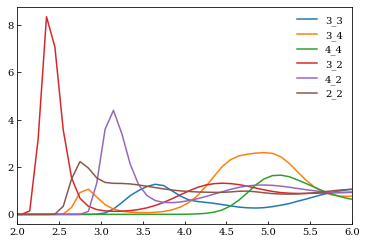

In [23]:
import matplotlib.pyplot as plt
for tag in ['3_3','3_4','4_4','3_2','4_2','2_2']:
    rdf = np.loadtxt('/home/yunqi/proj_cond/pt_nacl_const/results/210426/'
                     f'512_0percconst/5mol/rdf_{tag}.dat')
    plt.plot(rdf[:,0], rdf[:,1], label=tag)
plt.xlim(2,6)
plt.legend()

## G2 symmetry function

| I  | J | $r_s\ [Å]$ | $\eta\ [Å^{-2}]$                             |
|----|---|------------|----------------------------------------------|
| H  | H | `0.000 `   | `0.003571, 0.03571, 0.1071, 0.2143`          |
|    |   | `1.005 `   | `0.5357,   1.071,   2.143,  5.357 `          |
| H  | O | `0.000 `   | `0.003571, 0.03571, 0.1071, 0.2143`          |
|    |   | `0.4763`   | `0.5357,   1.071,   2.143,  5.357 `          |
| O  | O | `0.000 `   | `0.003571, 0.03571, 0.1071, 0.2143`          |
|    |   | `2.117 `   | `0.5357,   1.071,   2.143,  5.357 `          |
| Na | H | `0.000 `   | `0.003571, 0.03571, 0.1071, 0.2500, 0.05357` |
|    |   | `1.058 `   | `0.5357,   1.071,   2.143,  5.357 `          |
| Na | O | `0.000 `   | `0.003571, 0.03571, 0.1071, 0.2500, 0.05357` |
|    |   | `1.852 `   | `0.5357,   1.071,   2.143,  5.357 `          |

